In [15]:
import time


def run_function(func, *args, **kwargs):
    start_time = time.time()
    ret = None
    try:

        ret = func(*args, **kwargs)

    except Exception as e:
        print(f"Error running function: {e}")

    end_time = time.time()
    latency = end_time - start_time
    return latency, ret


In [16]:
import os
os.environ['REPLICATE_API_TOKEN'] = "..."

In [17]:
# Import groundedness feedback function
from trulens_eval import  Feedback
from test_cases import generate_summeval_groundedness_golden_set


# generator for groundedness golden set
test_cases_gen = generate_summeval_groundedness_golden_set("./datasets/summeval/summeval_test_100.json")

### Benchmarking Mixtral 8x7b and Llama3-70b on 2 inference platforms: Replicate vs Cortex 

In [18]:
test_split = []


for i in range(100):
    test_split.append(next(test_cases_gen))

In [ ]:
from trulens_eval.feedback.provider import Cortex
from trulens_eval.feedback import LiteLLM


replicate_provider_llama3_70b = LiteLLM(model_engine="replicate/meta/meta-llama-3-70b")
f_groundedness_replicate_llama3 = Feedback(replicate_provider_llama3_70b.groundedness_measure_with_cot_reasons, name = "Replicate Llama-3-70b").on_input_output()


replicate_provider_mixtral = LiteLLM(model_engine="replicate/mistralai/mixtral-8x7b-instruct-v0.1")
f_groundedness_replicate_mixtral = Feedback(replicate_provider_mixtral.groundedness_measure_with_cot_reasons, name = "Replicate Mixtral-8x7b-instruct-v0.1").on_input_output()



cortex_provider_llama3_70b = Cortex(model_engine="llama3-70b")
f_groundedness_cortex_llama3 = Feedback(cortex_provider_llama3_70b.groundedness_measure_with_cot_reasons, name = "Cortex Llama-3-70b").on_input_output()

cortex_provider_mixtral = Cortex(model_engine="mixtral-8x7b")
f_groundedness_cortex_mixtral = Feedback(cortex_provider_mixtral.groundedness_measure_with_cot_reasons, name = "Cortex Mixtral-8x7b").on_input_output()



In [20]:
latencies_replicate_mixtral = []
latencies_cortex_mixtral = [] 

responses_replicate_mixtral = []
responses_cortex_mixtral = []

In [ ]:
for i in range(len(test_split)):
    source = test_split[i]["query"]
    response = test_split[i]["response"]
    res_replicate = run_function(f_groundedness_replicate_mixtral, source, response)
    latencies_replicate_mixtral.append(res_replicate[0])
    responses_replicate_mixtral.append(res_replicate[1])
    
    res_cortex = run_function(f_groundedness_cortex_mixtral, source, response)
    latencies_cortex_mixtral.append(res_cortex[0])
    responses_cortex_mixtral.append(res_cortex[1])
    

In [25]:
import numpy as np
def compute_stats(latencies):
    return {
        "mean": np.mean(latencies),
        "min": np.min(latencies),
        "max": np.max(latencies),
        "std": np.std(latencies),
        "p90": np.percentile(latencies, 90),
        "p95": np.percentile(latencies, 95),
        "p99": np.percentile(latencies, 99),
    }
    

def plot_latencies(latencies, title):
    import matplotlib.pyplot as plt
    plt.plot(latencies)
    plt.title(title)
    plt.xlabel("Test Case Index")
    plt.ylabel("Latency")
    plt.show()

{'mean': 2.312637186050415, 'min': 1.1355009078979492, 'max': 3.151073694229126, 'std': 0.4159016964174797, 'p90': 2.855151128768923, 'p95': 3.090414249897003, 'p99': 3.1349924349784852}


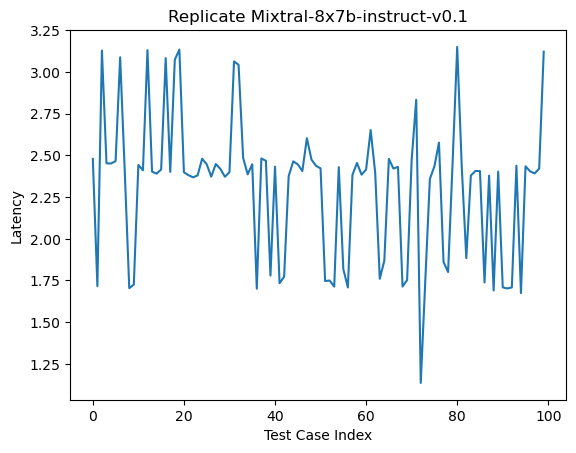

{'mean': 3.567398090362549, 'min': 0.838623046875, 'max': 42.16298794746399, 'std': 4.643209521315515, 'p90': 6.791606235504151, 'p95': 8.806894600391386, 'p99': 14.434614391327047}


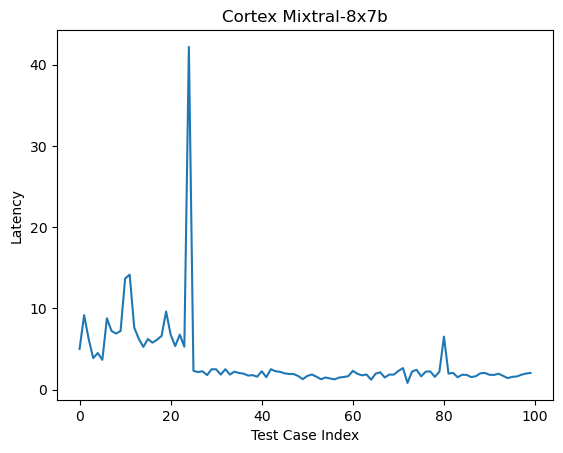

In [27]:
import numpy as np
import matplotlib.pyplot as plt




replicate_stats = compute_stats(latencies_replicate_mixtral)
print(replicate_stats)

plot_latencies(latencies_replicate_mixtral, "Replicate Mixtral-8x7b-instruct-v0.1")

cortex_stats = compute_stats(latencies_cortex_mixtral)
print(cortex_stats)

plot_latencies(latencies_cortex_mixtral, "Cortex Mixtral-8x7b")







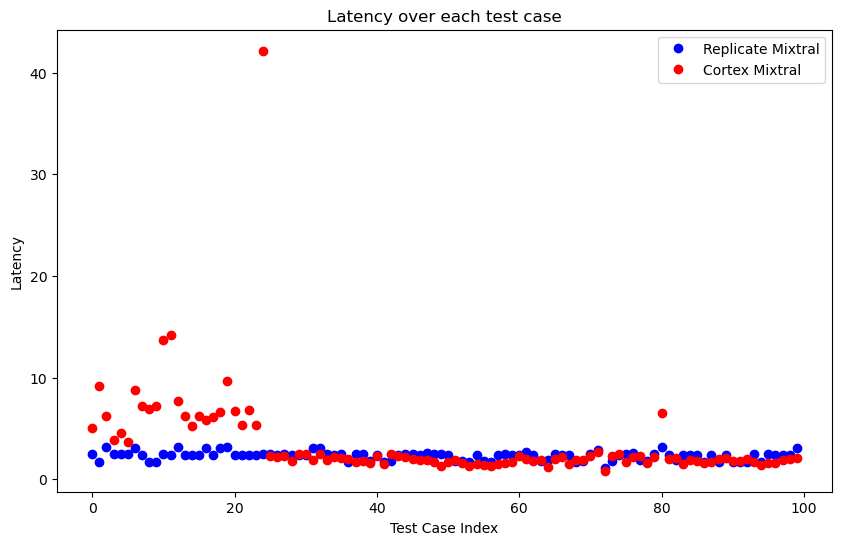

In [48]:
plt.figure(figsize=(10, 6))

plt.plot([i for i in range(len(test_split))], latencies_replicate_mixtral, 'o', label='Replicate Mixtral', color='blue')
plt.plot([i for i in range(len(test_split))], latencies_cortex_mixtral, 'o', label='Cortex Mixtral', color='red')


plt.xlabel('Test Case Index')
plt.ylabel('Latency')
plt.title('Latency over each test case')
plt.legend()  
# Display the plot
plt.show()

In [49]:
import numpy as np


# Convert the list to a NumPy array
latencies_cortex_mixtral = np.array(latencies_cortex_mixtral)

# Find the index of the largest value
index_of_largest_value = np.argmax(latencies_cortex_mixtral)

print("Index of the largest value:", index_of_largest_value)

Index of the largest value: 24


In [52]:
test_split[24]

{'query': '(CNN)A North Pacific gray whale has earned a spot in the record books after completing the longest migration of a mammal ever recorded. The whale, named Varvara, swam nearly 14,000 miles (22,500 kilometers), according to a release from Oregon State University, whose scientists helped conduct the whale-tracking study. Varvara, which is Russian for "Barbara," left her primary feeding ground off Russia\'s Sakhalin Island to cross the  Pacific Ocean and down the West Coast of the United States to Baja, Mexico. Varvara\'s journey surpassed a record listed on the Guinness Worlds Records website. It said the previous record was set by a humpback whale that swam a mere 10,190-mile round trip between the "warm breeding waters near the equator and the colder food-rich waters of the Arctic and Antarctic regions." Records are nice, but Bruce Mate, the lead author of the study, thinks the long trip might say more about the whale than just its ability to swim. During her 14,000-mile journ

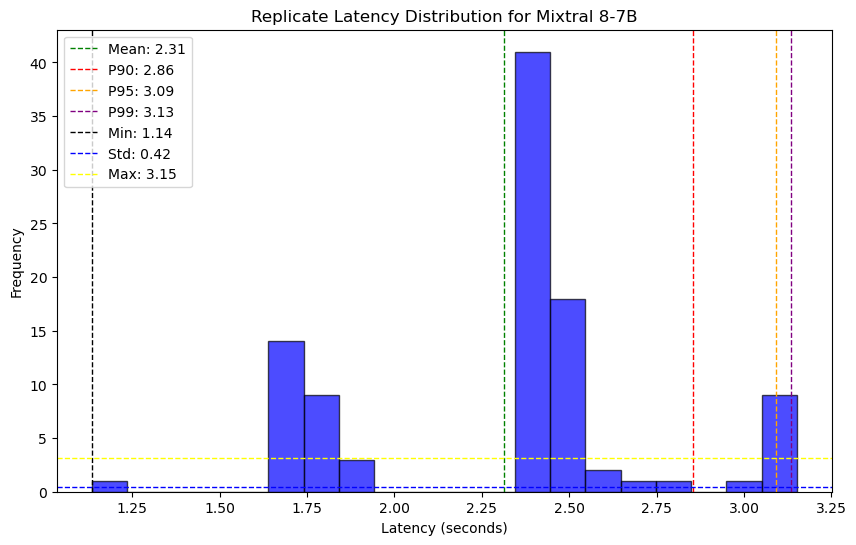

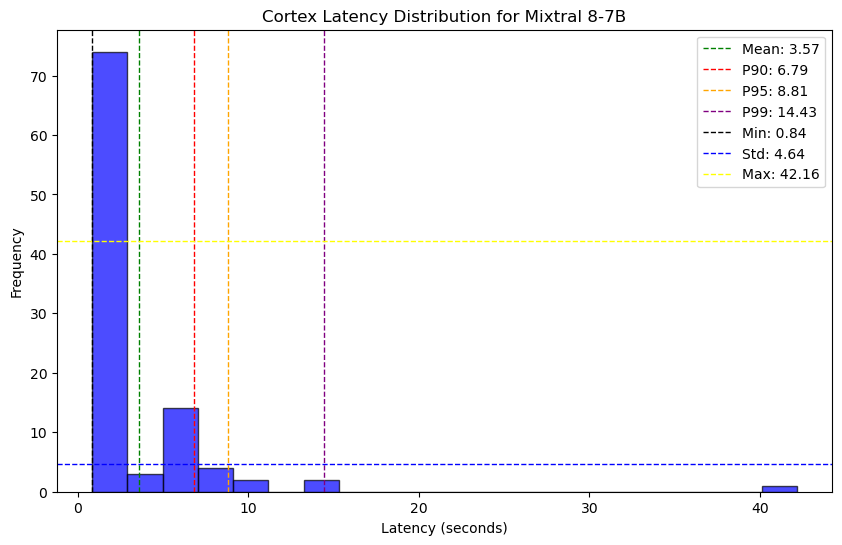

In [39]:

def plot_latency_distribution(latencies, stats_dict: dict, title: str):
    
    plt.figure(figsize=(10, 6))
    plt.hist(latencies, bins=20, alpha=0.7, color='blue', edgecolor='black')

    # Adding lines for mean and percentiles
    plt.axvline(stats_dict["mean"], color='green', linestyle='dashed', linewidth=1, label=f'Mean: {stats_dict["mean"]:.2f}')
    plt.axvline(stats_dict['p90'], color='red', linestyle='dashed', linewidth=1, label=f'P90: {stats_dict["p90"]:.2f}')
    plt.axvline(stats_dict['p95'], color='orange', linestyle='dashed', linewidth=1, label=f'P95: {stats_dict["p95"]:.2f}')
    plt.axvline(stats_dict['p99'], color='purple', linestyle='dashed', linewidth=1, label=f'P99: {stats_dict["p99"]:.2f}')
    plt.axvline(stats_dict['min'], color='black', linestyle='dashed', linewidth=1, label=f'Min: {stats_dict["min"]:.2f}')
    plt.axhline(stats_dict['std'], color='blue', linestyle='dashed', linewidth=1, label=f'Std: {stats_dict["std"]:.2f}')
    plt.axhline(stats_dict['max'], color='yellow', linestyle='dashed', linewidth=1, label=f'Max: {stats_dict["max"]:.2f}')

    # Adding labels and legend
    plt.xlabel('Latency (seconds)')
    plt.ylabel('Frequency')
    # plt.title('Cortex Latency Distribution for Mixtral 8-7B')
    plt.title(title)
    plt.legend()

    # Display the plot
    plt.show()

plot_latency_distribution(latencies_replicate_mixtral, replicate_stats, "Replicate Latency Distribution for Mixtral 8-7B")
 

### prompt length analysis


In [32]:
from trulens_eval.feedback import prompts
groundedness_system_prompt = prompts.LLM_GROUNDEDNESS_SYSTEM
groundedness_user_prompt = prompts.LLM_GROUNDEDNESS_USER

In [33]:
sys_prompt_len = len(groundedness_system_prompt)
user_prompt_len = len(groundedness_user_prompt)

In [34]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt', quiet=True)

True

In [35]:
input_prompt_len = []
for i in range(len(test_split)):
    source = test_split[i]["query"]
    response = test_split[i]["response"]
    
    input_len_per_hypothesis_eval = 0

    hypotheses = sent_tokenize(response)
    
    for hypothesis in hypotheses:
        input_len_per_hypothesis_eval += len(source) + sys_prompt_len + len(hypothesis) + user_prompt_len
    
    input_prompt_len.append(input_len_per_hypothesis_eval)


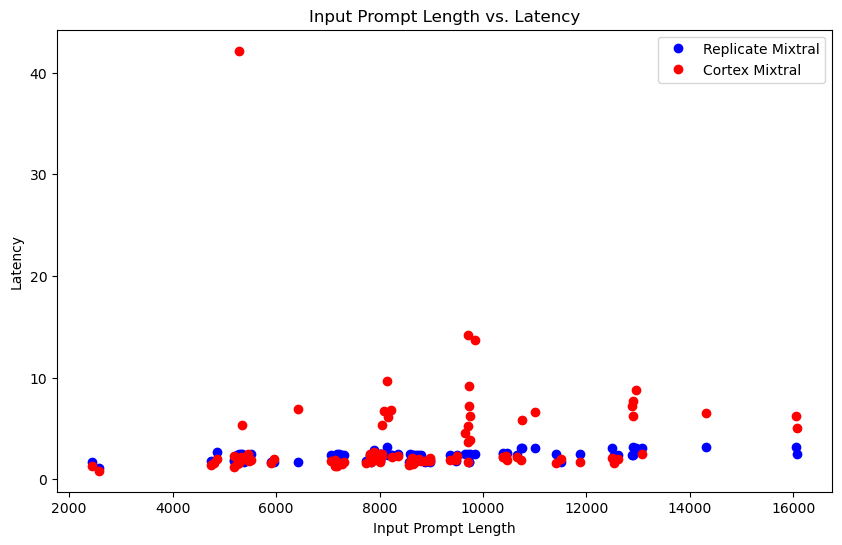

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(input_prompt_len, latencies_replicate_mixtral, 'o', label='Replicate Mixtral', color='blue')
plt.plot(input_prompt_len, latencies_cortex_mixtral, 'o', label='Cortex Mixtral', color='red')


plt.xlabel('Input Prompt Length')
plt.ylabel('Latency')
plt.title('Input Prompt Length vs. Latency')
plt.legend()  
# Display the plot
plt.show()